# Project: Investigate a Dataset - [Database_soccer]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> In this project 1, I willl be analysing ultimate soccer dataset, which is an open-source dataset in kaggle. The dataset is a one .sql file comprising seven tables, each with different(unique) but interrelated features. First, Country table has 11 European countries. Second, league table has 11 lead championship names. The country and league tables are related by their ID. Third, match table has over 25, 000 matches for different seasons as well as betting odds from upto 10 providers. The match table is also related to the previous tables by country_id. in the rows and 2 columns id and name
I have check the shape of table to determine the nummber of rows and columns.


### Question(s) for Analysis
1. What teams improved the most over the time period? 
2. Which players had the most penalties? 
3. Which was the the most preferred leg for penalty-takers in 2016 among the players who scored more than the mean penalties in that year?

In [1]:
# import statements for all of the packages to be used.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

I want to create a function that would read csv and load for very dataset to a name variable

In [6]:
# creating function to load data
path='C:/Users/Davie/Desktop/Data/'
def load_data(name, table_name):
    name=pd.read_csv(path + 'Database_Soccer/'+ table_name) # reads the csv file and stores in the dataframe name
    return name

displaying few lines of each dataset from the soccer database

In [7]:
country=load_data('country', 'Country.csv')# country data table
country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [8]:
league=load_data('league', 'League.csv')# league data table
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


From the league name above, the league name for Germany is confusing. Germany 1. could mean there are a number of German countries, so it should be change to Germany Bundesliga 1

In [9]:
match=load_data('match', 'Match.csv')# match data table
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


missing data in match table

In [10]:
player=load_data('player', 'Player.csv')# player data table
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


The birthday contains time at 00:00:00, which could be removed to contain only year, month and date

In [11]:
player_attr=load_data('player_attr', 'Player_Attributes.csv')# player attributes data table
player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


The time 00:00:00 can be removed

In [12]:
team=load_data('team', 'Team.csv')# team data table
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


The column team_fifa_api_id could insignificant because there is already team_api_id

In [13]:
team_attr=load_data('team_attr', 'Team_Attributes.csv')# team attributes data table
team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


I want again to develop a function that I will be using in inspecting the datasets for missing data, getting descriptive statistics, dimensions, and features' data types

In [14]:
# creating function for inspecting the datasets
def wrangles (tbl_name):
    
    inf=tbl_name.info(); # inspecting data types and instances with missing data 
    dim=tbl_name.shape; # inspecting dimensions of the dataset
    desc=tbl_name.describe(); # getting descriptive statistics
        
    return inf, dim, desc

In [15]:
# country dataset
wrangles(country)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


(None,
 (11, 2),
                  id
 count     11.000000
 mean   12452.090909
 std     8215.308472
 min        1.000000
 25%     6289.000000
 50%    13274.000000
 75%    18668.000000
 max    24558.000000)

There is no need of getting the mean for ids, since the names are string we can just unique values and counts 

In [16]:
country.name.describe()

count          11
unique         11
top       Belgium
freq            1
Name: name, dtype: object

In [17]:
# league data
wrangles(league)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


(None,
 (11, 3),
                  id    country_id
 count     11.000000     11.000000
 mean   12452.090909  12452.090909
 std     8215.308472   8215.308472
 min        1.000000      1.000000
 25%     6289.000000   6289.000000
 50%    13274.000000  13274.000000
 75%    18668.000000  18668.000000
 max    24558.000000  24558.000000)

There is no need of getting the mean for ids, since the names are string we can just unique values and counts

In [18]:
league.name.describe()

count                         11
unique                        11
top       Belgium Jupiler League
freq                           1
Name: name, dtype: object

In [19]:
# match data
wrangles(match)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


(None,
 (25979, 115),
                  id    country_id     league_id         stage  match_api_id  \
 count  25979.000000  25979.000000  25979.000000  25979.000000  2.597900e+04   
 mean   12990.000000  11738.630317  11738.630317     18.242773  1.195429e+06   
 std     7499.635658   7553.936759   7553.936759     10.407354  4.946279e+05   
 min        1.000000      1.000000      1.000000      1.000000  4.831290e+05   
 25%     6495.500000   4769.000000   4769.000000      9.000000  7.684365e+05   
 50%    12990.000000  10257.000000  10257.000000     18.000000  1.147511e+06   
 75%    19484.500000  17642.000000  17642.000000     27.000000  1.709852e+06   
 max    25979.000000  24558.000000  24558.000000     38.000000  2.216672e+06   
 
        home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
 count      25979.000000      25979.000000    25979.000000    25979.000000   
 mean        9984.371993       9984.475115        1.544594        1.160938   
 std        14087.4537

missing data for column home_player_x1

In [20]:
match.dtypes

id              int64
country_id      int64
league_id       int64
season         object
stage           int64
               ...   
GBD           float64
GBA           float64
BSH           float64
BSD           float64
BSA           float64
Length: 115, dtype: object

the date has been stored as a string

In [21]:
# player data
wrangles(player)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


(None,
 (11060, 7),
                  id  player_api_id  player_fifa_api_id        height  \
 count  11060.000000   11060.000000        11060.000000  11060.000000   
 mean    5537.511392  156582.427215       165664.910488    181.867445   
 std     3197.692647  160713.700624        58649.928360      6.369201   
 min        1.000000    2625.000000            2.000000    157.480000   
 25%     2767.750000   35555.500000       151889.500000    177.800000   
 50%     5536.500000   96619.500000       184671.000000    182.880000   
 75%     8306.250000  212470.500000       203883.250000    185.420000   
 max    11075.000000  750584.000000       234141.000000    208.280000   
 
              weight  
 count  11060.000000  
 mean     168.380289  
 std       14.990217  
 min      117.000000  
 25%      159.000000  
 50%      168.000000  
 75%      179.000000  
 max      243.000000  )

birthday column stored as string

In [22]:
# player attributes data
wrangles(player_attr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

(None,
 (183978, 42),
                  id  player_fifa_api_id  player_api_id  overall_rating  \
 count  183978.00000       183978.000000  183978.000000   183142.000000   
 mean    91989.50000       165671.524291  135900.617324       68.600015   
 std     53110.01825        53851.094769  136927.840510        7.041139   
 min         1.00000            2.000000    2625.000000       33.000000   
 25%     45995.25000       155798.000000   34763.000000       64.000000   
 50%     91989.50000       183488.000000   77741.000000       69.000000   
 75%    137983.75000       199848.000000  191080.000000       73.000000   
 max    183978.00000       234141.000000  750584.000000       94.000000   
 
            potential       crossing      finishing  heading_accuracy  \
 count  183142.000000  183142.000000  183142.000000     183142.000000   
 mean       73.460353      55.086883      49.921078         57.266023   
 std         6.592271      17.242135      19.038705         16.488905   
 min     

dates stored as string

In [23]:
# team data
wrangles(team)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


(None,
 (299, 5),
                  id    team_api_id  team_fifa_api_id
 count    299.000000     299.000000        288.000000
 mean   23735.301003   12340.521739      21534.305556
 std    15167.914719   25940.411135      42456.439408
 min        1.000000    1601.000000          1.000000
 25%     9552.500000    8349.000000        178.750000
 50%    22805.000000    8655.000000        673.500000
 75%    36250.500000    9886.500000       1910.750000
 max    51606.000000  274581.000000     112513.000000)

Missing data for team_fifa_api_id, though this might be insignificant since there is already team_api_id

In [24]:
# team attributes data
wrangles(team_attr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

(None,
 (1458, 25),
                 id  team_fifa_api_id    team_api_id  buildUpPlaySpeed  \
 count  1458.000000       1458.000000    1458.000000       1458.000000   
 mean    729.500000      17706.982167    9995.727023         52.462277   
 std     421.032659      39179.857739   13264.869900         11.545869   
 min       1.000000          1.000000    1601.000000         20.000000   
 25%     365.250000        110.000000    8457.750000         45.000000   
 50%     729.500000        485.000000    8674.000000         52.000000   
 75%    1093.750000       1900.000000    9904.000000         62.000000   
 max    1458.000000     112513.000000  274581.000000         80.000000   
 
        buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
 count            489.000000         1458.000000            1458.000000   
 mean              48.607362           48.490398              52.165295   
 std                9.678290           10.896101              10.360793   
 min        

Missing data for buildUpPlayDribbling


### Data Cleaning

First, I want to create functions that will help me drop duplicates, merge two datasets, change data type, remove missing rows, drop unnecessary columns, then proceed to to merge the country data to that for league. 
I will correct the league name for Germany 1. Bundesliga to Germany Bundesliga 1.
I will also change the name column for both the country data and league data, and also make the datafrmaes have the same dimensions and finally merge the two dataframes into country_league data using the country id as the key

In [21]:
# creating function to rename columns in a data frame
def col_rename(col_renamed_data, col_old, col_new):
    if len(col_old)==2: # checks if there are two columns to be renamed
        col_renamed_data.rename(columns={col_old[0]:col_new[0], col_old[1]:col_new[1]}, inplace=True) # renames the two columns in the dataset
    else:
        col_renamed_data.rename(columns={col_old:col_new}, inplace=True) # renames if there is only one column to be renamed
        
    return col_renamed_data

In [22]:
# creating a function drop columns
def drop_cols(drop_col_data, col_name):
    drop_col_data.drop(col_name, axis=1, inplace=True) # removing columns
        
    return drop_col_data

In [23]:
# creating a function to remove row missing values
def remove_row_missing_values(na_data):
    na_data.dropna(axis=0, how='any', inplace=True) # removing all rows with missing values
        
    return na_data

In [24]:
# creating a function to remove duplicate rows
def remove_duplicates(dup_data, col):
    if col=='':
        dup_data.drop_duplicates(inplace=True) # remove all duplicate rows
        
    else:
        dup_data.dropna(subset=[col], inplace=True) # removing rows based on column duplicate values
        
    return dup_data

In [25]:
# creating a function to change date column from string to datetime
def changed_type(changed_type_data, col_type):
    changed_type_data[col_type]=changed_type_data[col_type].astype('str')  # converting to string
    changed_type_data[col_type]=changed_type_data[col_type].str.extract(r'(\d{4}-\d{2}-\d{2})') # extracting the date
    changed_type_data[col_type] = pd.to_datetime(changed_type_data[col_type], format='%Y-%m-%d') # converting to datetime

    return changed_type_data

In [26]:
# creating a function to filter some columns
def filter_col(f_data, col):
    df=f_data.filter(col) # filters the columns
        
    return df

In [27]:
# creating a function to to merge two data frames using inner because i dont want do keep duplicates
def merging_data(data1, data2, on_col):
    df=data1.merge(data2, on =on_col, how='inner')
        
    return df

In [28]:
# correcting the league name for Germany 1. Bundesliga
league.replace(to_replace='Germany 1. Bundesliga', value='Germany Bundesliga 1', inplace=True)

In [29]:
# changing both id and name columns for the country data
country=col_rename(country, col_old=['name', 'id'], col_new=['country_name', 'country_id']) 
country 

,country_id,country_name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [30]:
# changing the name column and id column  for the league data
league=col_rename(league, col_old=['name', 'id'], col_new=['league_name', 'league_id']) 
league

,league_id,country_id,league_name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany Bundesliga 1
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [31]:
# merging the two dataframes country and league
country_league_info=merging_data(country, league, on_col ='country_id')
country_league_info

,country_id,country_name,league_id,league_name
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany Bundesliga 1
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


Second, I want to merge the player data to player attributes data into player_info dataframe.
I will use either the player_api_id or player_fifa_api_id as the keys and drop the id columns in both datasets


In [32]:
# checking the number of unique values of player_api_id on payer and player attribute data
player.player_api_id.nunique()==player_attr.player_api_id.nunique()

True

In [33]:
# checking the number of unique values of  player_fifa_api_id on player and player attribute data
player.player_fifa_api_id.nunique()==player_attr.player_fifa_api_id.nunique()

False

Since the number of unique values of the player_fifa_api_id are not the same in both dataframes, I will just use both of them as the key because both the ids might be important in merging this data with another one

In [34]:
# dropping id column from player dataframe
drop_cols(player, col_name='id')
player.head()

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [35]:
# dropping id column from player_attr dataframe
drop_cols(player_attr, col_name='id')
player_attr.shape

(183978, 41)

In [36]:
# removing duplicates for player attribute data
remove_duplicates(player_attr, col='')
player_attr.sort_values(['player_api_id', 'date']) # sorting the players by id and date

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
139856,148544,2625,2007-02-22 00:00:00,63.0,64.0,right,high,medium,48.0,48.0,...,56.0,46.0,64.0,66.0,63.0,14.0,11.0,67.0,9.0,10.0
139855,148544,2625,2007-08-30 00:00:00,63.0,64.0,right,high,medium,48.0,48.0,...,56.0,46.0,64.0,66.0,63.0,14.0,24.0,67.0,24.0,24.0
139854,148544,2625,2008-08-30 00:00:00,60.0,64.0,right,high,medium,48.0,48.0,...,56.0,46.0,64.0,66.0,63.0,14.0,24.0,67.0,24.0,24.0
139853,148544,2625,2010-08-30 00:00:00,60.0,64.0,right,high,medium,48.0,48.0,...,56.0,69.0,64.0,66.0,63.0,12.0,11.0,6.0,8.0,8.0
139852,148544,2625,2011-02-22 00:00:00,59.0,63.0,right,high,medium,52.0,47.0,...,55.0,66.0,63.0,63.0,62.0,12.0,11.0,6.0,8.0,8.0
139851,148544,2625,2011-08-30 00:00:00,58.0,58.0,right,high,medium,52.0,47.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139850,148544,2625,2012-02-22 00:00:00,58.0,58.0,right,medium,medium,52.0,47.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139849,148544,2625,2012-08-31 00:00:00,58.0,58.0,right,medium,medium,52.0,47.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139848,148544,2625,2013-02-15 00:00:00,58.0,58.0,right,medium,medium,52.0,47.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139847,148544,2625,2013-03-08 00:00:00,61.0,61.0,right,medium,medium,50.0,47.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0


In [37]:
# joining the two dataframes on player_api_id and player_fifa_api_id using inner join because i dont want the unmatched rows
player_info=merging_data(player, player_attr, on_col =['player_api_id', 'player_fifa_api_id'])
player_info

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-21 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-07 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-01-07 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-24 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-17 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


I now want o examine the player_info dataframe, check for missing values, dimensions of each column, data types of each column as well as duplcate values

In [38]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183766 entries, 0 to 183765
Data columns (total 45 columns):
player_api_id          183766 non-null int64
player_name            183766 non-null object
player_fifa_api_id     183766 non-null int64
birthday               183766 non-null object
height                 183766 non-null float64
weight                 183766 non-null int64
date                   183766 non-null object
overall_rating         183016 non-null float64
potential              183016 non-null float64
preferred_foot         183016 non-null object
attacking_work_rate    180622 non-null object
defensive_work_rate    183016 non-null object
crossing               183016 non-null float64
finishing              183016 non-null float64
heading_accuracy       183016 non-null float64
short_passing          183016 non-null float64
volleys                181139 non-null float64
dribbling              183016 non-null float64
curve                  181139 non-null float64
free_kic

From the above uotput, there are several missing values, the data type for birthday and date are all strings. I have also noted that attacking_work_rate has the least number of rows hence maximum number of missing values

In [39]:
# getting the uniques for the coulmn attacking_work_rate
player_info.attacking_work_rate.unique()

array(['medium', 'high', nan, 'low', 'None', 'le', 'norm', 'stoc', 'y'], dtype=object)

I want to drop all rows with nan and duplicate rows

In [40]:
# dropping all rows with missing data
remove_row_missing_values(player_info) 

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-21 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-07 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-01-07 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-24 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-17 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [41]:
# dropping duplicate rows
remove_duplicates(player_info, col='')

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-21 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-04-07 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2016-01-07 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-24 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,2015-12-17 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [42]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180228 entries, 0 to 183765
Data columns (total 45 columns):
player_api_id          180228 non-null int64
player_name            180228 non-null object
player_fifa_api_id     180228 non-null int64
birthday               180228 non-null object
height                 180228 non-null float64
weight                 180228 non-null int64
date                   180228 non-null object
overall_rating         180228 non-null float64
potential              180228 non-null float64
preferred_foot         180228 non-null object
attacking_work_rate    180228 non-null object
defensive_work_rate    180228 non-null object
crossing               180228 non-null float64
finishing              180228 non-null float64
heading_accuracy       180228 non-null float64
short_passing          180228 non-null float64
volleys                180228 non-null float64
dribbling              180228 non-null float64
curve                  180228 non-null float64
free_kic

In [43]:
player_info.attacking_work_rate.value_counts()

medium    125022
high       42775
low         8569
None        3287
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64

In [44]:
player_info.defensive_work_rate.value_counts()

medium    130785
high       27041
low        18426
o           1328
1            421
ormal        317
2            299
3            232
5            231
7            207
0            188
6            166
9            143
4            116
es            94
tocky         86
ean           78
8             70
Name: defensive_work_rate, dtype: int64

From the output in above two cells, no information has been provided from the data description about the meaning of None, norm, y, stoc, le, ornal, es, tocky, ean o, and the numbers 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9 . Howerver, from inspection, I realize that there is some association in that all the numbers 0-9 and o on the defensive_work_rate relates to None  on the attacking_work_rate. Also, the following  pairs also relate: norm-ornal, y-es, stoc-tocky, le-ean. These could be change or transformed if additional information is provided or simply be dropped from the analysis

In [45]:
attacking_none=player_info.query('attacking_work_rate=="None"')
attacking_none

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
675,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-03-24 00:00:00,73.0,75.0,right,...,71.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
676,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-02-25 00:00:00,72.0,74.0,right,...,71.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
677,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-01-07 00:00:00,72.0,74.0,right,...,74.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
678,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2015-09-21 00:00:00,72.0,74.0,right,...,74.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
679,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2015-07-03 00:00:00,71.0,73.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0
680,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2015-01-30 00:00:00,71.0,73.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0
681,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2014-11-14 00:00:00,71.0,75.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0
682,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2014-09-18 00:00:00,71.0,75.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0
683,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2014-07-18 00:00:00,72.0,75.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0
684,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2014-02-14 00:00:00,72.0,75.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0


In [46]:
# comparing length of numbers 0-9 and o in the defensive_work_rate relates to None in the attacking_work_rate

attacking_none.attacking_work_rate.value_counts()==attacking_none.defensive_work_rate.value_counts().sum()

None    True
Name: attacking_work_rate, dtype: bool

I want to change the data types for birthday and date from string to datetime

In [47]:
# converting birthday column into datetime
changed_type(player_info, col_type='birthday')

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-21 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-07 00:00:00,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-01-07 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2015-12-24 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2015-12-17 00:00:00,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [48]:
# converting date column into datetime
changed_type(player_info, col_type='date')

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2016-02-18,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-11-19,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-09-21,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-03-20,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2007-02-22,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-21,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-07,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-01-07,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2015-12-24,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2015-12-17,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [49]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180228 entries, 0 to 183765
Data columns (total 45 columns):
player_api_id          180228 non-null int64
player_name            180228 non-null object
player_fifa_api_id     180228 non-null int64
birthday               180228 non-null datetime64[ns]
height                 180228 non-null float64
weight                 180228 non-null int64
date                   180228 non-null datetime64[ns]
overall_rating         180228 non-null float64
potential              180228 non-null float64
preferred_foot         180228 non-null object
attacking_work_rate    180228 non-null object
defensive_work_rate    180228 non-null object
crossing               180228 non-null float64
finishing              180228 non-null float64
heading_accuracy       180228 non-null float64
short_passing          180228 non-null float64
volleys                180228 non-null float64
dribbling              180228 non-null float64
curve                  180228 non-null 

Third, I want merge team data to team attributes data into into team info dataframe, check data types, missing values

In [50]:
# checking the number of unique values of team_api_id in team and team attribute data
team.team_api_id.nunique()==team_attr.team_api_id.nunique()

False

In [51]:
# checking the number of unique values of team_fifa_api_id in team and team attribute data
team.team_fifa_api_id.nunique()==team_attr.team_fifa_api_id.nunique()

True

From these outputs, it is clear that neither the team_api_id nor the team_fifa_api_id matches in the two datasets. I will therefore merge them on both the team_api_id and team_fifa_api_id as the keys

In [52]:
# dropping the id for team dataframe
drop_cols(team, col_name='id')

,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,9987,673.0,KRC Genk,GEN
1,9993,675.0,Beerschot AC,BAC
2,10000,15005.0,SV Zulte-Waregem,ZUL
3,9994,2007.0,Sporting Lokeren,LOK
4,9984,1750.0,KSV Cercle Brugge,CEB
5,8635,229.0,RSC Anderlecht,AND
6,9991,674.0,KAA Gent,GEN
7,9998,1747.0,RAEC Mons,MON
8,7947,NaN,FCV Dender EH,DEN
9,9985,232.0,Standard de Liège,STL


In [53]:
team.team_long_name.unique()

array(['KRC Genk', 'Beerschot AC', 'SV Zulte-Waregem', 'Sporting Lokeren',
       'KSV Cercle Brugge', 'RSC Anderlecht', 'KAA Gent', 'RAEC Mons',
       'FCV Dender EH', 'Standard de Liège', 'KV Mechelen',
       'Club Brugge KV', 'KSV Roeselare', 'KV Kortrijk', 'Tubize',
       'Royal Excel Mouscron', 'KVC Westerlo', 'Sporting Charleroi',
       'Sint-Truidense VV', 'Lierse SK', 'KAS Eupen',
       'Oud-Heverlee Leuven', 'Waasland-Beveren', 'KV Oostende',
       'Manchester United', 'Newcastle United', 'Arsenal',
       'West Bromwich Albion', 'Sunderland', 'Liverpool',
       'West Ham United', 'Wigan Athletic', 'Aston Villa',
       'Manchester City', 'Everton', 'Blackburn Rovers', 'Middlesbrough',
       'Tottenham Hotspur', 'Bolton Wanderers', 'Stoke City', 'Hull City',
       'Fulham', 'Chelsea', 'Portsmouth', 'Birmingham City',
       'Wolverhampton Wanderers', 'Burnley', 'Blackpool', 'Swansea City',
       'Queens Park Rangers', 'Norwich City', 'Southampton', 'Reading',
       

I want to correct the following team names: '1. FC Köln', '1. FC Nürnberg', '1. FSV Mainz 05','1. FC Kaiserslautern'

In [54]:
# correcting some team names
team.team_long_name.replace(to_replace=['1. FC Köln', '1. FC Nürnberg', '1. FSV Mainz 05','1. FC Kaiserslautern'], 
                            value=['FC Köln', 'FC Nürnberg', 'FSV Mainz 05','FC Kaiserslautern'], inplace=True)

In [55]:
# dropping the id for team attributes data
drop_cols(team_attr, col_name='id')

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,77,8485,2012-02-22 00:00:00,58,Balanced,NaN,Little,62,Mixed,Organised,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,77,8485,2013-09-20 00:00:00,62,Balanced,NaN,Little,45,Mixed,Organised,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover
7,77,8485,2014-09-19 00:00:00,58,Balanced,64.0,Normal,62,Mixed,Organised,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,77,8485,2015-09-10 00:00:00,59,Balanced,64.0,Normal,53,Mixed,Organised,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
9,614,8576,2010-02-22 00:00:00,60,Balanced,NaN,Little,40,Mixed,Organised,...,55,Normal,Organised,30,Deep,70,Double,30,Narrow,Offside Trap


In [56]:
# merging team to the team attribute
team_info=team.merge(team_attr, on =['team_api_id', 'team_fifa_api_id'], how='inner')
team_info

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673.0,KRC Genk,GEN,2010-02-22 00:00:00,45,Balanced,NaN,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673.0,KRC Genk,GEN,2011-02-22 00:00:00,66,Balanced,NaN,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673.0,KRC Genk,GEN,2012-02-22 00:00:00,53,Balanced,NaN,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673.0,KRC Genk,GEN,2013-09-20 00:00:00,58,Balanced,NaN,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673.0,KRC Genk,GEN,2014-09-19 00:00:00,58,Balanced,52.0,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
5,9987,673.0,KRC Genk,GEN,2015-09-10 00:00:00,58,Balanced,52.0,Normal,38,...,56,Normal,Organised,36,Medium,57,Press,70,Wide,Cover
6,9993,675.0,Beerschot AC,BAC,2010-02-22 00:00:00,35,Balanced,NaN,Little,35,...,50,Normal,Organised,70,High,70,Double,70,Wide,Cover
7,9993,675.0,Beerschot AC,BAC,2011-02-22 00:00:00,47,Balanced,NaN,Little,37,...,67,Lots,Organised,33,Deep,34,Press,48,Normal,Offside Trap
8,9993,675.0,Beerschot AC,BAC,2012-02-22 00:00:00,55,Balanced,NaN,Little,55,...,49,Normal,Organised,45,Medium,46,Press,50,Normal,Cover
9,9993,675.0,Beerschot AC,BAC,2013-09-20 00:00:00,47,Balanced,NaN,Little,39,...,49,Normal,Organised,45,Medium,46,Press,67,Wide,Cover


I will populate the NaN in the buildUpPlayDribbling column with the mean of the column. And finally drop duplcates in the final dataframe

In [57]:
# getting the mean of buildUpPlayDribbling column
mean=team_info.buildUpPlayDribbling.mean()

# filling the NaNs in the buildUpPlayDribbling by the mean
team_info['buildUpPlayDribbling']=team_info['buildUpPlayDribbling'].fillna(mean)

In [58]:
# converting to datetime
changed_type(team_info, col_type='date')

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673.0,KRC Genk,GEN,2010-02-22,45,Balanced,48.607362,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673.0,KRC Genk,GEN,2011-02-22,66,Balanced,48.607362,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673.0,KRC Genk,GEN,2012-02-22,53,Balanced,48.607362,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673.0,KRC Genk,GEN,2013-09-20,58,Balanced,48.607362,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673.0,KRC Genk,GEN,2014-09-19,58,Balanced,52.000000,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
5,9987,673.0,KRC Genk,GEN,2015-09-10,58,Balanced,52.000000,Normal,38,...,56,Normal,Organised,36,Medium,57,Press,70,Wide,Cover
6,9993,675.0,Beerschot AC,BAC,2010-02-22,35,Balanced,48.607362,Little,35,...,50,Normal,Organised,70,High,70,Double,70,Wide,Cover
7,9993,675.0,Beerschot AC,BAC,2011-02-22,47,Balanced,48.607362,Little,37,...,67,Lots,Organised,33,Deep,34,Press,48,Normal,Offside Trap
8,9993,675.0,Beerschot AC,BAC,2012-02-22,55,Balanced,48.607362,Little,55,...,49,Normal,Organised,45,Medium,46,Press,50,Normal,Cover
9,9993,675.0,Beerschot AC,BAC,2013-09-20,47,Balanced,48.607362,Little,39,...,49,Normal,Organised,45,Medium,46,Press,67,Wide,Cover


In [59]:
# dropping the duplicate rows in the final team info merged data
remove_duplicates(team_info, col='')

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673.0,KRC Genk,GEN,2010-02-22,45,Balanced,48.607362,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673.0,KRC Genk,GEN,2011-02-22,66,Balanced,48.607362,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673.0,KRC Genk,GEN,2012-02-22,53,Balanced,48.607362,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673.0,KRC Genk,GEN,2013-09-20,58,Balanced,48.607362,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673.0,KRC Genk,GEN,2014-09-19,58,Balanced,52.000000,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
5,9987,673.0,KRC Genk,GEN,2015-09-10,58,Balanced,52.000000,Normal,38,...,56,Normal,Organised,36,Medium,57,Press,70,Wide,Cover
6,9993,675.0,Beerschot AC,BAC,2010-02-22,35,Balanced,48.607362,Little,35,...,50,Normal,Organised,70,High,70,Double,70,Wide,Cover
7,9993,675.0,Beerschot AC,BAC,2011-02-22,47,Balanced,48.607362,Little,37,...,67,Lots,Organised,33,Deep,34,Press,48,Normal,Offside Trap
8,9993,675.0,Beerschot AC,BAC,2012-02-22,55,Balanced,48.607362,Little,55,...,49,Normal,Organised,45,Medium,46,Press,50,Normal,Cover
9,9993,675.0,Beerschot AC,BAC,2013-09-20,47,Balanced,48.607362,Little,39,...,49,Normal,Organised,45,Medium,46,Press,67,Wide,Cover


In [60]:
team_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1457
Data columns (total 26 columns):
team_api_id                       1457 non-null int64
team_fifa_api_id                  1457 non-null float64
team_long_name                    1457 non-null object
team_short_name                   1457 non-null object
date                              1457 non-null datetime64[ns]
buildUpPlaySpeed                  1457 non-null int64
buildUpPlaySpeedClass             1457 non-null object
buildUpPlayDribbling              1457 non-null float64
buildUpPlayDribblingClass         1457 non-null object
buildUpPlayPassing                1457 non-null int64
buildUpPlayPassingClass           1457 non-null object
buildUpPlayPositioningClass       1457 non-null object
chanceCreationPassing             1457 non-null int64
chanceCreationPassingClass        1457 non-null object
chanceCreationCrossing            1457 non-null int64
chanceCreationCrossingClass       1457 non-null object
chanceCr

In [61]:
team_info.head()

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673.0,KRC Genk,GEN,2010-02-22,45,Balanced,48.607362,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673.0,KRC Genk,GEN,2011-02-22,66,Balanced,48.607362,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673.0,KRC Genk,GEN,2012-02-22,53,Balanced,48.607362,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673.0,KRC Genk,GEN,2013-09-20,58,Balanced,48.607362,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673.0,KRC Genk,GEN,2014-09-19,58,Balanced,52.000000,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover


Finally, I to examine and merge match data, country_league, and team data to form march info dataframe. I will check for duplicates, missing values and correct data types

In [62]:
# checking the number of league_id unique values in the match and country_league_info dataframes
match.league_id.nunique()==country_league_info.league_id.nunique()

True

In [63]:
# checking the number of country_id unique values in the match and country_league_info dataframes
match.country_id.nunique()==country_league_info.country_id.nunique()

True

I will merge match and country_league_info dataframes on league_id and country_id, so that I retain all the info about ids. I want to drop all the columns containing odds

In [64]:
for i in match.columns:
    print(i)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

I want to remove all the columns with CAPITAL LETTERS, odds columns

In [65]:
# converting to datetime for the match data
changed_type(match, col_type='date')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
5,6,1,1,2008/2009,1,2008-09-24,492478,8203,8342,1,...,1.67,4.35,3.40,1.70,4.50,3.40,1.70,NaN,NaN,NaN
6,7,1,1,2008/2009,1,2008-08-16,492479,9999,8571,2,...,3.60,2.10,3.25,3.00,1.85,3.25,3.75,2.10,3.25,3.10
7,8,1,1,2008/2009,1,2008-08-16,492480,4049,9996,1,...,2.40,2.80,3.25,2.25,2.80,3.20,2.25,2.88,3.25,2.20
8,9,1,1,2008/2009,1,2008-08-16,492481,10001,9986,1,...,3.10,2.25,3.25,2.80,2.20,3.30,2.80,2.25,3.20,2.80
9,10,1,1,2008/2009,10,2008-11-01,492564,8342,8571,4,...,10.00,1.30,4.35,8.50,1.25,5.00,10.00,1.29,4.50,9.00


In [66]:
# dropping the duplicate rows from match data
remove_duplicates(match, col='')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
5,6,1,1,2008/2009,1,2008-09-24,492478,8203,8342,1,...,1.67,4.35,3.40,1.70,4.50,3.40,1.70,NaN,NaN,NaN
6,7,1,1,2008/2009,1,2008-08-16,492479,9999,8571,2,...,3.60,2.10,3.25,3.00,1.85,3.25,3.75,2.10,3.25,3.10
7,8,1,1,2008/2009,1,2008-08-16,492480,4049,9996,1,...,2.40,2.80,3.25,2.25,2.80,3.20,2.25,2.88,3.25,2.20
8,9,1,1,2008/2009,1,2008-08-16,492481,10001,9986,1,...,3.10,2.25,3.25,2.80,2.20,3.30,2.80,2.25,3.20,2.80
9,10,1,1,2008/2009,10,2008-11-01,492564,8342,8571,4,...,10.00,1.30,4.35,8.50,1.25,5.00,10.00,1.29,4.50,9.00


In [67]:
# dropping the columns containg odds and the match id
odd_cols = list(filter(lambda x: x.isupper(), match.columns))
drop_cols(match, col_name=odd_cols)
drop_cols(match, col_name='id')
match.tail()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
25974,24558,24558,2015/2016,9,2015-09-22,1992091,10190,10191,1,0,...,232110.0,289732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,24558,24558,2015/2016,9,2015-09-23,1992092,9824,10199,1,2,...,34082.0,95257.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,24558,24558,2015/2016,9,2015-09-23,1992093,9956,10179,2,0,...,451335.0,275122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,24558,24558,2015/2016,9,2015-09-22,1992094,7896,10243,0,0,...,92252.0,194532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,24558,24558,2015/2016,9,2015-09-23,1992095,10192,9931,4,3,...,41726.0,527103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# checking the contents of some columns
```match.goal.value_counts() # goal```

From the above two cells, I realised that the coulmns goal, shoton, shotoff, foulcommit, card, cross, corner and possession contains information related to the web page but not realistic data.Checking through the nested infomation, I can't really make sense out of it since even the website link to discription is not loading. Instead of deleting the columns with such issues, I will instead drop the columns containing unprocessed data

In [68]:
match_info=filter_col(match, col=['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal'])

match_info.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3


In [69]:
# melt home and away teams id_vars are columns not melted
# creating columns not melted
unmelted_columns= [x for x in match_info.columns if x not in ['home_team_api_id', 'away_team_api_id']]

# melting home and away teams api ids
melted_match=match_info.melt(id_vars=unmelted_columns, var_name='Location', value_name='Team')
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,Location,Team
0,1,1,2008/2009,1,2008-08-17,492473,1,1,home_team_api_id,9987
1,1,1,2008/2009,1,2008-08-16,492474,0,0,home_team_api_id,10000
2,1,1,2008/2009,1,2008-08-16,492475,0,3,home_team_api_id,9984
3,1,1,2008/2009,1,2008-08-17,492476,5,0,home_team_api_id,9991
4,1,1,2008/2009,1,2008-08-16,492477,1,3,home_team_api_id,7947


In [70]:
# cleaning up or changing the location values
melted_match['Location']=melted_match['Location'].replace({'home_team_api_id':'home', 'away_team_api_id':'away'})
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,Location,Team
0,1,1,2008/2009,1,2008-08-17,492473,1,1,home,9987
1,1,1,2008/2009,1,2008-08-16,492474,0,0,home,10000
2,1,1,2008/2009,1,2008-08-16,492475,0,3,home,9984
3,1,1,2008/2009,1,2008-08-17,492476,5,0,home,9991
4,1,1,2008/2009,1,2008-08-16,492477,1,3,home,7947


In [71]:
# creating team dictionary with team api ids as the key and a longname as the value
team_dict=team.set_index('team_api_id')['team_long_name'].to_dict()
team_dict

{9987: 'KRC Genk',
 9993: 'Beerschot AC',
 10000: 'SV Zulte-Waregem',
 9994: 'Sporting Lokeren',
 9984: 'KSV Cercle Brugge',
 8635: 'RSC Anderlecht',
 9991: 'KAA Gent',
 9998: 'RAEC Mons',
 7947: 'FCV Dender EH',
 9985: 'Standard de Liège',
 8203: 'KV Mechelen',
 8342: 'Club Brugge KV',
 9999: 'KSV Roeselare',
 8571: 'KV Kortrijk',
 4049: 'Tubize',
 9996: 'Royal Excel Mouscron',
 10001: 'KVC Westerlo',
 9986: 'Sporting Charleroi',
 9997: 'Sint-Truidense VV',
 9989: 'Lierse SK',
 6351: 'KAS Eupen',
 1773: 'Oud-Heverlee Leuven',
 8475: 'Waasland-Beveren',
 8573: 'KV Oostende',
 274581: 'Royal Excel Mouscron',
 10260: 'Manchester United',
 10261: 'Newcastle United',
 9825: 'Arsenal',
 8659: 'West Bromwich Albion',
 8472: 'Sunderland',
 8650: 'Liverpool',
 8654: 'West Ham United',
 8528: 'Wigan Athletic',
 10252: 'Aston Villa',
 8456: 'Manchester City',
 8668: 'Everton',
 8655: 'Blackburn Rovers',
 8549: 'Middlesbrough',
 8586: 'Tottenham Hotspur',
 8559: 'Bolton Wanderers',
 10194: 'Stoke

In [72]:
# cleaning up team i.e. using team dictionary to replace team api ids
melted_match['Team']=melted_match['Team'].map(team_dict)
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,Location,Team
0,1,1,2008/2009,1,2008-08-17,492473,1,1,home,KRC Genk
1,1,1,2008/2009,1,2008-08-16,492474,0,0,home,SV Zulte-Waregem
2,1,1,2008/2009,1,2008-08-16,492475,0,3,home,KSV Cercle Brugge
3,1,1,2008/2009,1,2008-08-17,492476,5,0,home,KAA Gent
4,1,1,2008/2009,1,2008-08-16,492477,1,3,home,FCV Dender EH


In [73]:
# creating goals colum
melted_match['goals']=np.where(melted_match['Location']=='home',melted_match['home_team_goal'], melted_match['away_team_goal'])
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,Location,Team,goals
0,1,1,2008/2009,1,2008-08-17,492473,1,1,home,KRC Genk,1
1,1,1,2008/2009,1,2008-08-16,492474,0,0,home,SV Zulte-Waregem,0
2,1,1,2008/2009,1,2008-08-16,492475,0,3,home,KSV Cercle Brugge,0
3,1,1,2008/2009,1,2008-08-17,492476,5,0,home,KAA Gent,5
4,1,1,2008/2009,1,2008-08-16,492477,1,3,home,FCV Dender EH,1


In [74]:
drop_cols(melted_match, col_name=['home_team_goal', 'away_team_goal'])
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,Location,Team,goals
0,1,1,2008/2009,1,2008-08-17,492473,home,KRC Genk,1
1,1,1,2008/2009,1,2008-08-16,492474,home,SV Zulte-Waregem,0
2,1,1,2008/2009,1,2008-08-16,492475,home,KSV Cercle Brugge,0
3,1,1,2008/2009,1,2008-08-17,492476,home,KAA Gent,5
4,1,1,2008/2009,1,2008-08-16,492477,home,FCV Dender EH,1


In [75]:
melted_match.sort_values(by=['match_api_id', 'season'])
melted_match.head()

,country_id,league_id,season,stage,date,match_api_id,Location,Team,goals
0,1,1,2008/2009,1,2008-08-17,492473,home,KRC Genk,1
1,1,1,2008/2009,1,2008-08-16,492474,home,SV Zulte-Waregem,0
2,1,1,2008/2009,1,2008-08-16,492475,home,KSV Cercle Brugge,0
3,1,1,2008/2009,1,2008-08-17,492476,home,KAA Gent,5
4,1,1,2008/2009,1,2008-08-16,492477,home,FCV Dender EH,1


<a id='eda'></a>
## Exploratory Data Analysis

# creating a function to plot different visualizations

In [76]:
def plot_visual(data, data2, visual_type):
    if visual_type=='barh':
        data.plot(kind='barh', rot=0, width=0.7, alpha=0.8, color='grey', figsize=[8,20] ) # i want to creat horizontal bars
            
    elif visual_type=='hist':
        fig,vis=plt.subplots(figsize=[10,8])
        vis.hist(data, alpha=0.8) # creating a histogram
        #plt.grid(axis='y', alpha=0.6) # grid
            
    elif visual_type=='boxplot':
        fig,vis=plt.subplots(figsize=[8,4])
        vis.boxplot(data, vert=0) # creating a box plot
        #plt.grid(axis='x', alpha=0.6)
                     
    else:
        fig, vis=plt.subplots(figsize=[10,8])
        plt.scatter(x=data, y=data2, alpha=0.8, color='blue') # creating scatter

### Research Question 1 What teams improved the most over the time period? 

Text(0,0.5,'No of goals scored in 2008/2009 and 2015/2015 season')

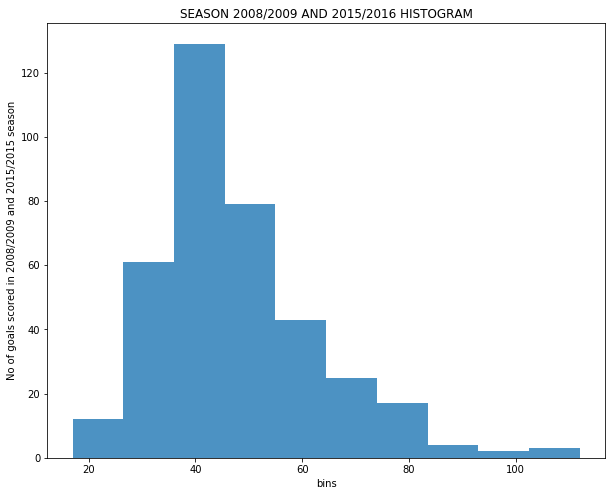

In [77]:
# checking the distribution of the extreme seasons
goal_08_16=melted_match.query('season in ["2008/2009", "2015/2016"]').groupby(['season', 'Team'])['goals'].sum()
# plot histogram
plot_visual(data=goal_08_16, data2='', visual_type='hist')
plt.title('SEASON 2008/2009 AND 2015/2016 HISTOGRAM')
plt.xlabel('bins')
plt.ylabel('No of goals scored in 2008/2009 and 2015/2015 season')

The graph shows that the distribution of goals is right screwed. Further investigation can be shown on the boxplot

Text(0,0.5,'2008/2009 and 2015/2015 season')

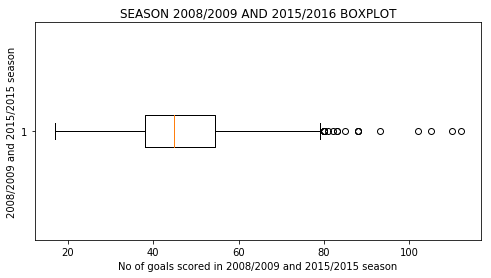

In [78]:
# plot box plot
plot_visual(data=goal_08_16, data2='', visual_type='boxplot')
plt.title('SEASON 2008/2009 AND 2015/2016 BOXPLOT')
plt.xlabel('No of goals scored in 2008/2009 and 2015/2015 season')
plt.ylabel('2008/2009 and 2015/2015 season')

The distribution is rght skewed but with severa outliers

In [79]:
# grouping by season and team
match_s08_15=melted_match.query('season in ["2008/2009", "2015/2016"]').groupby(['season', 'Team'])['goals'].sum().unstack('season')
match_s08_15.head()

season,2008/2009,2015/2016
Team,,
AC Bellinzona,44.0,NaN
ADO Den Haag,41.0,48.0
AJ Auxerre,35.0,NaN
AS Monaco,41.0,57.0
AS Nancy-Lorraine,38.0,NaN


Text(0,0.5,'Season 2015/2016')

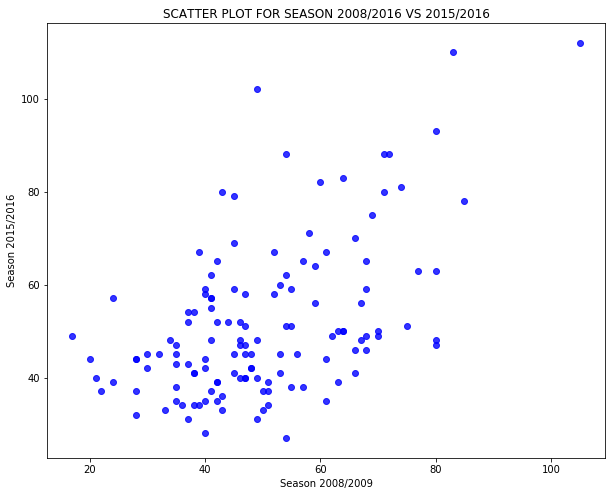

In [80]:
# plot a scatter diagram
plot_visual(data=match_s08_15['2008/2009'], data2=match_s08_15['2015/2016'], visual_type='scatter')
plt.title('SCATTER PLOT FOR SEASON 2008/2016 VS 2015/2016')
plt.xlabel('Season 2008/2009')
plt.ylabel('Season 2015/2016')

From the scatter plot, there is positive correlation between the number of goals scored in the season 2008/2009 and season 2015/2016

In [81]:
# get difference between columns 2008/2009 and 2015/2016 seasons
goal_diff=match_s08_15.dropna().diff(axis=1)
goal_diff.head()

season,2008/2009,2015/2016
Team,,
ADO Den Haag,NaN,7.0
AS Monaco,NaN,16.0
AS Saint-Étienne,NaN,2.0
AZ,NaN,4.0
Aberdeen,NaN,21.0


In [82]:
# goal difference in 2015/2016 season
goal_diff_16=goal_diff['2015/2016']
goal_mean=goal_diff_16[goal_diff_16>(goal_diff_16.mean())].sort_values(ascending=True)

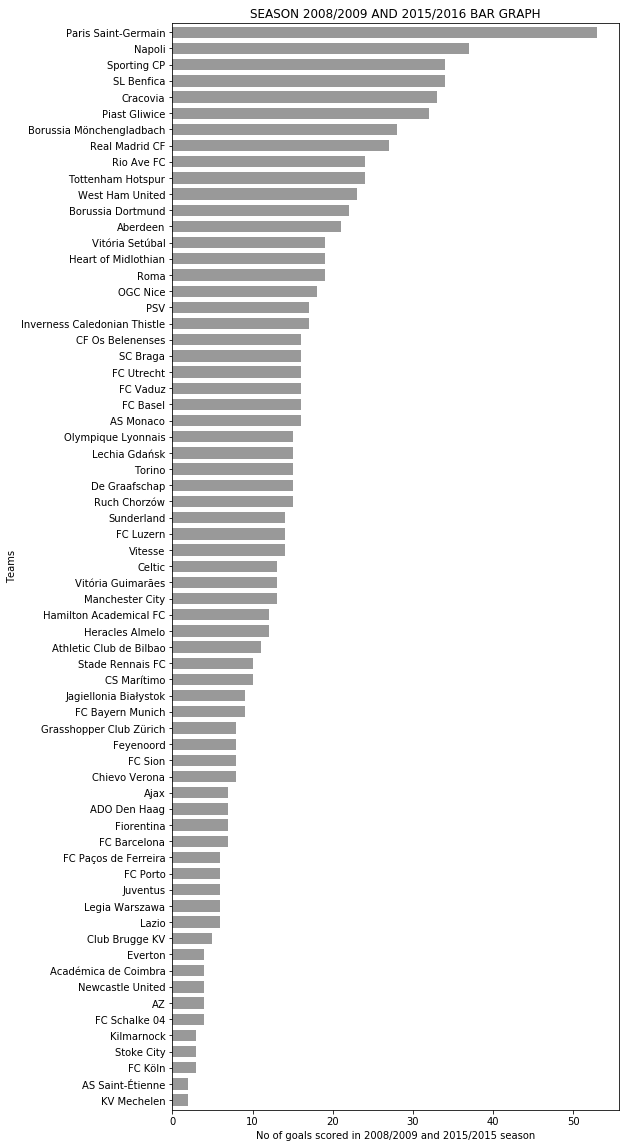

In [83]:
# plot bar graph for top 10 best teams
plot_visual(data=goal_mean, data2='', visual_type='barh')
plt.title('SEASON 2008/2009 AND 2015/2016 BAR GRAPH')
plt.xlabel('No of goals scored in 2008/2009 and 2015/2015 season')
plt.ylabel('Teams');

From the graph, the top 3 most improved teams are Paris Saint_Germain, Napoli and Cracovia in that order

### Research Question 2  Which players had the most penalties?

I want to filter and obtain the player who scored most of the penalties

In [84]:
# obtaining the name of the player
most_pen=player_info.query('penalties ==penalties.max()')

# creating dataframe for the player who had most penalties, avoiding duplicate name
most_pen.drop_duplicates(subset="player_api_id")

# printing 
most_pen

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
149441,39225,Rickie Lambert,13879,1982-02-16,187.96,170,2016-03-10,75.0,75.0,right,...,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0
149442,39225,Rickie Lambert,13879,1982-02-16,187.96,170,2015-12-24,75.0,75.0,right,...,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0
149443,39225,Rickie Lambert,13879,1982-02-16,187.96,170,2015-10-23,75.0,75.0,right,...,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0
149444,39225,Rickie Lambert,13879,1982-02-16,187.96,170,2015-09-21,75.0,75.0,right,...,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0


The table shows that the player that scored most of the penalties is Richie Lambert

### Research Question 3  Which was the the most preferred leg for penalty-takers in 2016 among the players who scored more than the mean penalties in that year?

Getting present in 2016

In [85]:
most_pen16=player_info.query('date>="2016.01.01"')
most_pen16

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2016-02-18,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-21,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-07,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-01-07,73.0,75.0,left,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,162549,Aaron Doran,186170,1991-05-13,170.18,163,2016-01-07,65.0,67.0,right,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,30572,Aaron Galindo,140161,1982-05-08,182.88,198,2016-04-21,69.0,69.0,right,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
112,27316,Aaron Hunt,158138,1986-09-04,182.88,161,2016-04-28,77.0,77.0,left,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
113,27316,Aaron Hunt,158138,1986-09-04,182.88,161,2016-02-25,77.0,77.0,left,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
139,564793,Aaron Kuhl,221280,1996-01-30,172.72,146,2016-04-21,61.0,74.0,right,...,61.0,42.0,52.0,58.0,57.0,8.0,13.0,14.0,14.0,15.0
140,564793,Aaron Kuhl,221280,1996-01-30,172.72,146,2016-02-04,61.0,75.0,right,...,61.0,42.0,52.0,58.0,57.0,8.0,13.0,14.0,14.0,15.0


In [86]:
# get the players who had penalties more than the mean penalties
pen_mean=most_pen16[most_pen16.penalties>most_pen16.penalties.mean()]
pen_mean.drop(['date'], axis=1)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
5,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,74.0,76.0,left,high,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,74.0,76.0,left,high,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,73.0,75.0,left,high,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,162549,Aaron Doran,186170,1991-05-13,170.18,163,65.0,67.0,right,medium,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
112,27316,Aaron Hunt,158138,1986-09-04,182.88,161,77.0,77.0,left,medium,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
113,27316,Aaron Hunt,158138,1986-09-04,182.88,161,77.0,77.0,left,medium,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
206,231592,Aaron Mooy,194958,1990-09-15,175.26,150,75.0,78.0,right,medium,...,81.0,73.0,56.0,65.0,62.0,11.0,8.0,12.0,11.0,12.0
207,231592,Aaron Mooy,194958,1990-09-15,175.26,150,74.0,77.0,right,medium,...,81.0,73.0,56.0,65.0,62.0,11.0,8.0,12.0,11.0,12.0
242,40719,Aaron Niguez,183853,1989-04-26,170.18,143,70.0,71.0,left,medium,...,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
243,40719,Aaron Niguez,183853,1989-04-26,170.18,143,70.0,72.0,left,medium,...,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0


In [87]:
# droping duplicates interms of player_api_id
pen_mean.drop_duplicates(subset=['player_api_id'])

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
5,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,2016-04-21,74.0,76.0,left,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,162549,Aaron Doran,186170,1991-05-13,170.18,163,2016-01-07,65.0,67.0,right,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
112,27316,Aaron Hunt,158138,1986-09-04,182.88,161,2016-04-28,77.0,77.0,left,...,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0
206,231592,Aaron Mooy,194958,1990-09-15,175.26,150,2016-02-04,75.0,78.0,right,...,81.0,73.0,56.0,65.0,62.0,11.0,8.0,12.0,11.0,12.0
242,40719,Aaron Niguez,183853,1989-04-26,170.18,143,2016-04-28,70.0,71.0,left,...,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
269,75489,Aaron Ramsey,186561,1990-12-26,177.80,154,2016-03-10,82.0,85.0,right,...,81.0,75.0,62.0,74.0,68.0,6.0,11.0,5.0,10.0,8.0
335,23499,Aaron Wilbraham,2335,1979-10-21,190.50,159,2016-04-21,65.0,65.0,right,...,68.0,73.0,23.0,20.0,19.0,12.0,13.0,10.0,10.0,9.0
357,120919,Aatif Chahechouhe,187939,1986-07-02,175.26,150,2016-05-12,75.0,75.0,right,...,70.0,85.0,26.0,27.0,24.0,7.0,10.0,8.0,15.0,10.0
378,167027,Abdelaziz Barrada,192274,1989-06-19,177.80,161,2016-06-23,74.0,75.0,right,...,74.0,71.0,35.0,42.0,33.0,11.0,7.0,6.0,16.0,7.0
415,42664,Abdelkader Ghezzal,178063,1984-12-05,182.88,172,2016-02-04,67.0,67.0,right,...,50.0,68.0,29.0,32.0,31.0,10.0,6.0,11.0,6.0,7.0


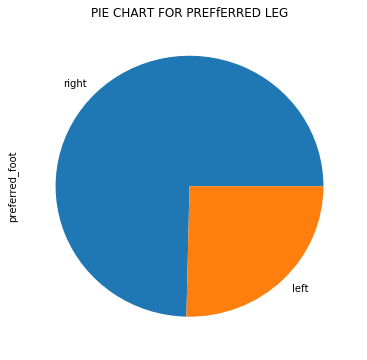

In [88]:
# creating a pie chart for the preffered leg
p=pen_mean['preferred_foot'].value_counts()
p.plot('pie', figsize=[6,6])
plt.title("PIE CHART FOR PREFfERRED LEG");

From the pie chart, most penalty takers in the year 2016 preffered right leg than left

<a id='conclusions'></a>
## Limitations
The soccer database is a very extensive data. In, seeking to address the three questions in the description, I was able to show only the correltaion between the number of goals scored in the two season. However, the other seasons were not considered.The data base had a lot of unprocessed  html files under certain columns, which made take a lot of time thinking on how well they can be used in the analysis. In addition, the data had a lot of missing and duplicate values. Identifying such inconsistencies, wss realy time consuming.

Another limitation is that in the creation of bar graph for the most improved teams, the bars are not sorted in order of either increasing or decreasing frequency, which would have enabled the identification of the improved teams easily. In getting the most preffered leg, it was only based on the year 2016 instead of the whole duration of time.

## Conclusions
The soccer database has five datasets, league, country, player, player attribute, team and team attribute. It is a detailed dabase for European major leagues covering several seasons from 2008/2009 t0 2015/2016. 

The project seeks to answer three questions, what teams improved the most over the time period, which players had the most penalties and which was the the most preferred leg for penalty-takers in 2016 among the players who scored more than the mean penalties in that year?

In attempting to find solutions to the question, each dataset was examineed for inconsistencies, colomn names, corrected, missing values replace or droped in certain datasets before they were finally merged and cleaned. Visual presentations created and inteprated.

From the analysis and visualization, Richie Lambert is the player who scored most of the penalties. I also found that Paris Saint-Germain is the most improved team over the period of time given, followed by Napoli and Cracovia being the in the third position. Moreover, the findings also indicate that most of the penalty takers in 2016 preferred right leg compared to the right leg. The findings also shows that the distribution of the number of goals scored in the two seasons are right skewed.

Whereas I was able to show that there is a correltaion between the number of goals scored in the two extreme seasons (2008/2009 and 2015/2016), theer are  other seasons that were not considered. There is likelihood that a team that improved between the two seasons might not have improved in the seasons prior 2015/2016. Goal difference between the two seasons was used as a measured of improvement in performance because the ultimate objective of team managers, players and teams is to improve to score goals, but there could be criteria for measuring performance.

In [89]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])